/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


Total edges
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ      0.0    1.0 -1.0042  1.0042  False
        CsCh     LDA_5DIZ      0.0    1.0 -0.9584  0.9584  False
        CsCh LDA_OCT_5DIZ  -1.7273 0.0012 -2.9313 -0.5232   True
        CsCh     OCT_5DIZ      0.0    1.0 -1.0183  1.0183  False
     Cs_5DIZ     LDA_5DIZ      0.0    1.0 -0.9944  0.9944  False
     Cs_5DIZ LDA_OCT_5DIZ  -1.7273 0.0017 -2.9602 -0.4943   True
     Cs_5DIZ     OCT_5DIZ      0.0    1.0 -1.0522  1.0522  False
    LDA_5DIZ LDA_OCT_5DIZ  -1.7273 0.0011 -2.9232 -0.5313   True
    LDA_5DIZ     OCT_5DIZ      0.0    1.0 -1.0086  1.0086  False
LDA_OCT_5DIZ     OCT_5DIZ   1.7273 0.0019  0.4829  2.9717   True
----------------------------------------------------------------


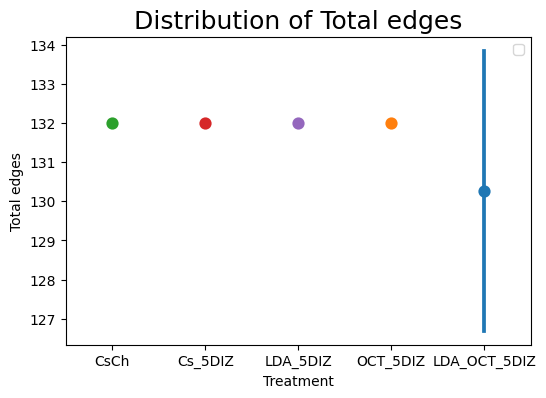

Degree heterogeneity
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ      0.0    1.0 -0.0142  0.0142  False
        CsCh     LDA_5DIZ      0.0    1.0 -0.0136  0.0136  False
        CsCh LDA_OCT_5DIZ   0.0264 0.0004  0.0093  0.0434   True
        CsCh     OCT_5DIZ      0.0    1.0 -0.0144  0.0144  False
     Cs_5DIZ     LDA_5DIZ      0.0    1.0 -0.0141  0.0141  False
     Cs_5DIZ LDA_OCT_5DIZ   0.0264 0.0006  0.0089  0.0438   True
     Cs_5DIZ     OCT_5DIZ      0.0    1.0 -0.0149  0.0149  False
    LDA_5DIZ LDA_OCT_5DIZ   0.0264 0.0004  0.0095  0.0433   True
    LDA_5DIZ     OCT_5DIZ      0.0    1.0 -0.0143  0.0143  False
LDA_OCT_5DIZ     OCT_5DIZ  -0.0264 0.0007  -0.044 -0.0088   True
----------------------------------------------------------------


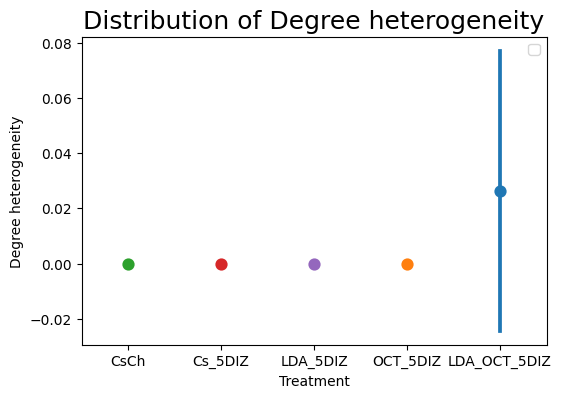

Reciprocity
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ      0.0    1.0 -0.0076  0.0076  False
        CsCh     LDA_5DIZ      0.0    1.0 -0.0073  0.0073  False
        CsCh LDA_OCT_5DIZ  -0.0111 0.0092 -0.0203  -0.002   True
        CsCh     OCT_5DIZ      0.0    1.0 -0.0077  0.0077  False
     Cs_5DIZ     LDA_5DIZ      0.0    1.0 -0.0076  0.0076  False
     Cs_5DIZ LDA_OCT_5DIZ  -0.0111 0.0117 -0.0205 -0.0017   True
     Cs_5DIZ     OCT_5DIZ      0.0    1.0  -0.008   0.008  False
    LDA_5DIZ LDA_OCT_5DIZ  -0.0111 0.0086 -0.0202  -0.002   True
    LDA_5DIZ     OCT_5DIZ      0.0    1.0 -0.0077  0.0077  False
LDA_OCT_5DIZ     OCT_5DIZ   0.0111 0.0129  0.0017  0.0206   True
----------------------------------------------------------------


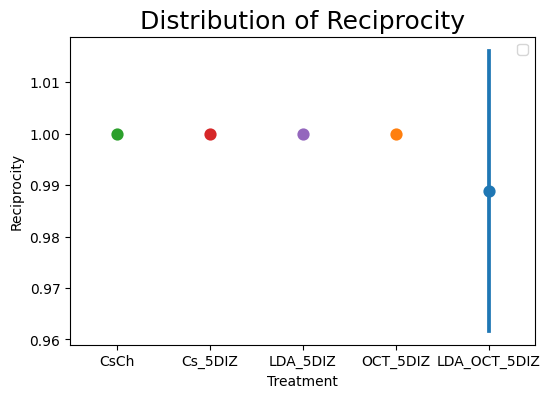

Network density
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ      0.0    1.0 -0.0076  0.0076  False
        CsCh     LDA_5DIZ      0.0    1.0 -0.0073  0.0073  False
        CsCh LDA_OCT_5DIZ  -0.0131 0.0012 -0.0222  -0.004   True
        CsCh     OCT_5DIZ      0.0    1.0 -0.0077  0.0077  False
     Cs_5DIZ     LDA_5DIZ      0.0    1.0 -0.0075  0.0075  False
     Cs_5DIZ LDA_OCT_5DIZ  -0.0131 0.0017 -0.0224 -0.0037   True
     Cs_5DIZ     OCT_5DIZ      0.0    1.0  -0.008   0.008  False
    LDA_5DIZ LDA_OCT_5DIZ  -0.0131 0.0011 -0.0221  -0.004   True
    LDA_5DIZ     OCT_5DIZ      0.0    1.0 -0.0076  0.0076  False
LDA_OCT_5DIZ     OCT_5DIZ   0.0131 0.0019  0.0037  0.0225   True
----------------------------------------------------------------


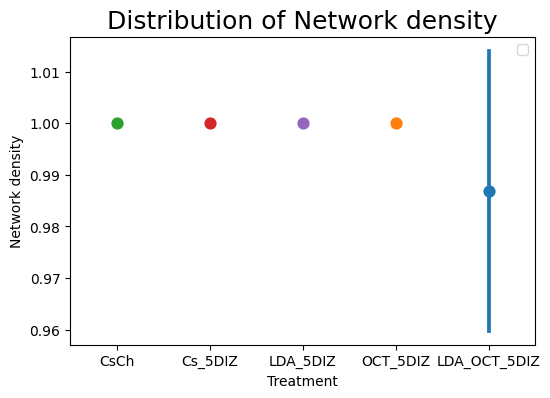

Transitivity
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ      0.0    1.0  -0.008   0.008  False
        CsCh     LDA_5DIZ      0.0    1.0 -0.0076  0.0076  False
        CsCh LDA_OCT_5DIZ  -0.0132 0.0022 -0.0227 -0.0036   True
        CsCh     OCT_5DIZ      0.0    1.0 -0.0081  0.0081  False
     Cs_5DIZ     LDA_5DIZ      0.0    1.0 -0.0079  0.0079  False
     Cs_5DIZ LDA_OCT_5DIZ  -0.0132 0.0029  -0.023 -0.0034   True
     Cs_5DIZ     OCT_5DIZ      0.0    1.0 -0.0084  0.0084  False
    LDA_5DIZ LDA_OCT_5DIZ  -0.0132  0.002 -0.0227 -0.0037   True
    LDA_5DIZ     OCT_5DIZ      0.0    1.0  -0.008   0.008  False
LDA_OCT_5DIZ     OCT_5DIZ   0.0132 0.0033  0.0033   0.023   True
----------------------------------------------------------------


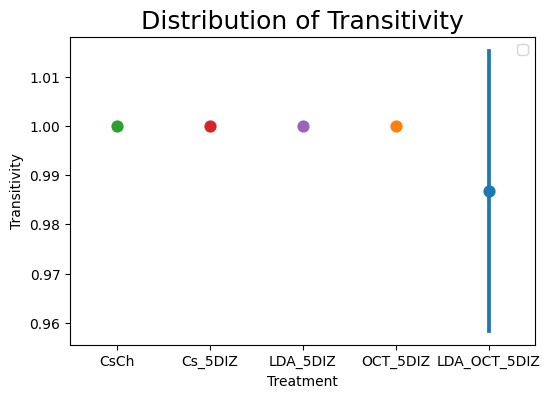

/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


Average clustering coefficient unweighted
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ      0.0    1.0 -0.0047  0.0047  False
        CsCh     LDA_5DIZ      0.0    1.0 -0.0044  0.0044  False
        CsCh LDA_OCT_5DIZ  -0.0088 0.0003 -0.0143 -0.0032   True
        CsCh     OCT_5DIZ      0.0    1.0 -0.0047  0.0047  False
     Cs_5DIZ     LDA_5DIZ      0.0    1.0 -0.0046  0.0046  False
     Cs_5DIZ LDA_OCT_5DIZ  -0.0088 0.0005 -0.0145  -0.003   True
     Cs_5DIZ     OCT_5DIZ      0.0    1.0 -0.0049  0.0049  False
    LDA_5DIZ LDA_OCT_5DIZ  -0.0088 0.0003 -0.0143 -0.0032   True
    LDA_5DIZ     OCT_5DIZ      0.0    1.0 -0.0047  0.0047  False
LDA_OCT_5DIZ     OCT_5DIZ   0.0088 0.0005   0.003  0.0145   True
----------------------------------------------------------------


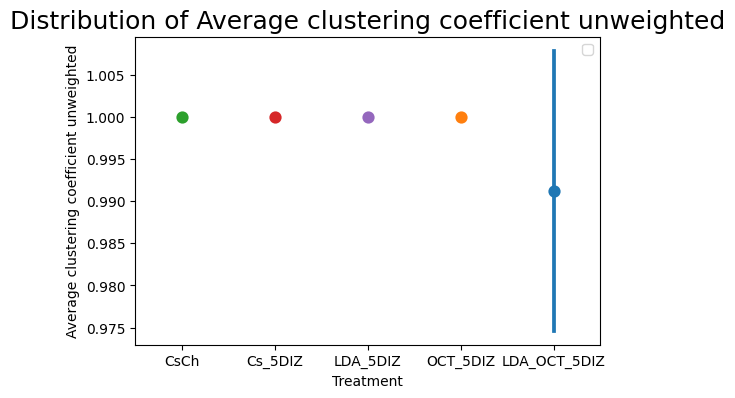

Average clustering coefficient weight=count
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ  -0.0347 0.3306 -0.0857  0.0164  False
        CsCh     LDA_5DIZ  -0.0395 0.1692 -0.0882  0.0092  False
        CsCh LDA_OCT_5DIZ  -0.0884 0.0011 -0.1497 -0.0272   True
        CsCh     OCT_5DIZ  -0.0444 0.1284 -0.0962  0.0074  False
     Cs_5DIZ     LDA_5DIZ  -0.0048 0.9989 -0.0554  0.0457  False
     Cs_5DIZ LDA_OCT_5DIZ  -0.0538 0.1283 -0.1165  0.0089  False
     Cs_5DIZ     OCT_5DIZ  -0.0097 0.9866 -0.0632  0.0438  False
    LDA_5DIZ LDA_OCT_5DIZ  -0.0489 0.1749 -0.1097  0.0119  False
    LDA_5DIZ     OCT_5DIZ  -0.0049 0.9989 -0.0562  0.0464  False
LDA_OCT_5DIZ     OCT_5DIZ    0.044 0.3059 -0.0192  0.1073  False
----------------------------------------------------------------


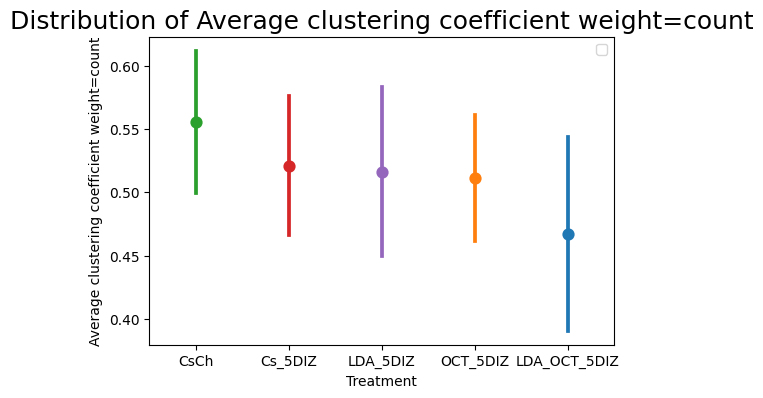

Average clustering coefficient weight=duration
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ   -0.028 0.8407 -0.1038  0.0477  False
        CsCh     LDA_5DIZ  -0.0467 0.3805  -0.119  0.0256  False
        CsCh LDA_OCT_5DIZ  -0.1227 0.0027 -0.2135 -0.0319   True
        CsCh     OCT_5DIZ  -0.0845 0.0237 -0.1613 -0.0077   True
     Cs_5DIZ     LDA_5DIZ  -0.0187 0.9575 -0.0937  0.0563  False
     Cs_5DIZ LDA_OCT_5DIZ  -0.0946  0.044 -0.1876 -0.0016   True
     Cs_5DIZ     OCT_5DIZ  -0.0564 0.2849 -0.1358  0.0229  False
    LDA_5DIZ LDA_OCT_5DIZ  -0.0759 0.1409 -0.1661  0.0143  False
    LDA_5DIZ     OCT_5DIZ  -0.0377 0.6419 -0.1138  0.0383  False
LDA_OCT_5DIZ     OCT_5DIZ   0.0382 0.7886 -0.0556  0.1321  False
----------------------------------------------------------------


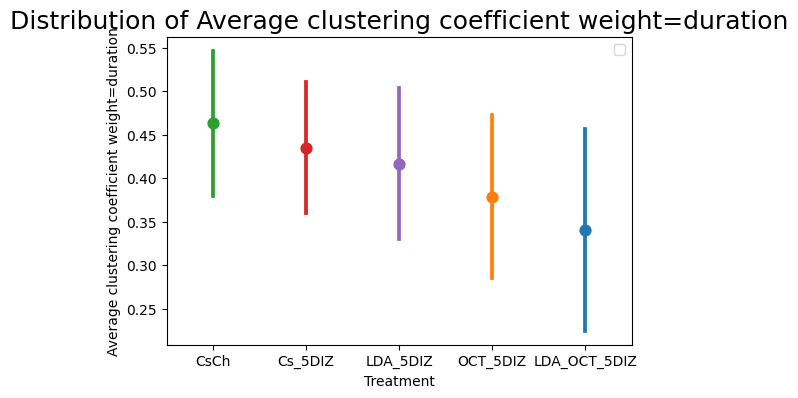

Average betweenness centrality unweighted
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ      0.0    1.0 -0.0004  0.0004  False
        CsCh     LDA_5DIZ      0.0    1.0 -0.0004  0.0004  False
        CsCh LDA_OCT_5DIZ   0.0006 0.0134  0.0001   0.001   True
        CsCh     OCT_5DIZ      0.0    1.0 -0.0004  0.0004  False
     Cs_5DIZ     LDA_5DIZ      0.0    1.0 -0.0004  0.0004  False
     Cs_5DIZ LDA_OCT_5DIZ   0.0006 0.0168  0.0001   0.001   True
     Cs_5DIZ     OCT_5DIZ      0.0    1.0 -0.0004  0.0004  False
    LDA_5DIZ LDA_OCT_5DIZ   0.0006 0.0126  0.0001   0.001   True
    LDA_5DIZ     OCT_5DIZ      0.0    1.0 -0.0004  0.0004  False
LDA_OCT_5DIZ     OCT_5DIZ  -0.0006 0.0183  -0.001 -0.0001   True
----------------------------------------------------------------


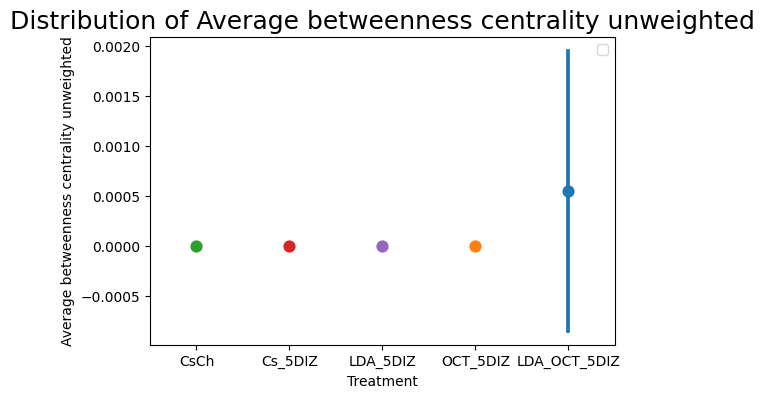

Average betweenness centrality weight=count
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ   0.0047 0.7793 -0.0066  0.0159  False
        CsCh     LDA_5DIZ   0.0026 0.9623 -0.0082  0.0133  False
        CsCh LDA_OCT_5DIZ   0.0234 0.0001  0.0099  0.0369   True
        CsCh     OCT_5DIZ   0.0063 0.5397 -0.0051  0.0177  False
     Cs_5DIZ     LDA_5DIZ  -0.0021 0.9856 -0.0132  0.0091  False
     Cs_5DIZ LDA_OCT_5DIZ   0.0188 0.0026  0.0049  0.0326   True
     Cs_5DIZ     OCT_5DIZ   0.0017 0.9949 -0.0101  0.0135  False
    LDA_5DIZ LDA_OCT_5DIZ   0.0208 0.0004  0.0074  0.0342   True
    LDA_5DIZ     OCT_5DIZ   0.0037 0.8895 -0.0076   0.015  False
LDA_OCT_5DIZ     OCT_5DIZ  -0.0171 0.0084  -0.031 -0.0031   True
----------------------------------------------------------------


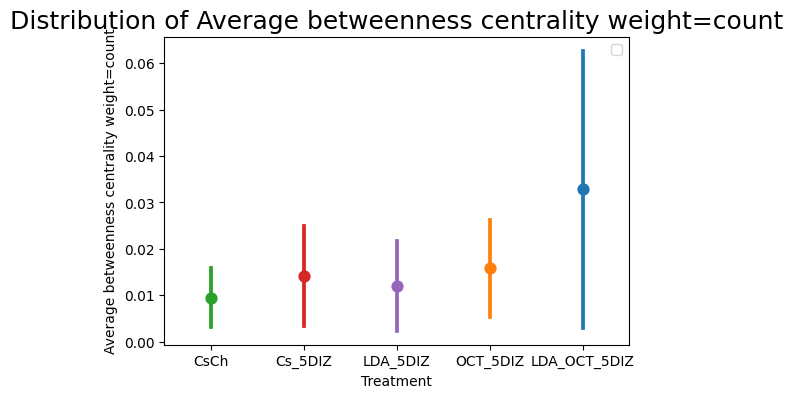

Average betweenness centrality weight=duration
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ   0.0062 0.6276 -0.0061  0.0184  False
        CsCh     LDA_5DIZ    0.003 0.9547 -0.0087  0.0146  False
        CsCh LDA_OCT_5DIZ   0.0275    0.0  0.0128  0.0422   True
        CsCh     OCT_5DIZ   0.0081 0.3732 -0.0043  0.0205  False
     Cs_5DIZ     LDA_5DIZ  -0.0032 0.9474 -0.0153  0.0089  False
     Cs_5DIZ LDA_OCT_5DIZ   0.0213 0.0014  0.0063  0.0364   True
     Cs_5DIZ     OCT_5DIZ   0.0019 0.9937 -0.0109  0.0147  False
    LDA_5DIZ LDA_OCT_5DIZ   0.0245 0.0001    0.01  0.0391   True
    LDA_5DIZ     OCT_5DIZ   0.0051 0.7748 -0.0072  0.0174  False
LDA_OCT_5DIZ     OCT_5DIZ  -0.0194 0.0051 -0.0346 -0.0043   True
----------------------------------------------------------------


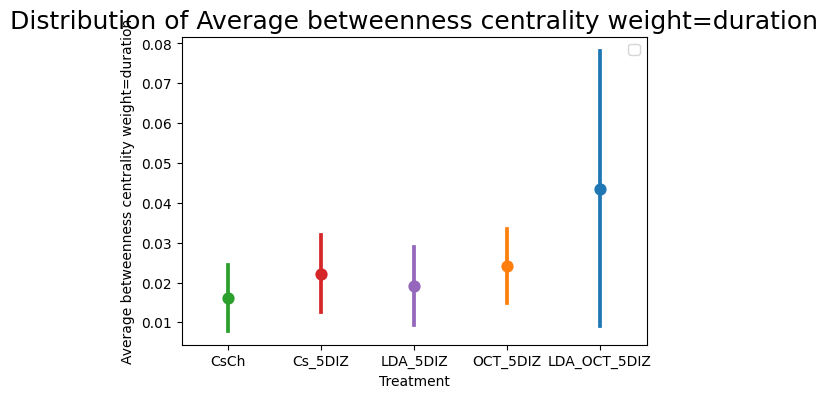

Average closseness centrality unweighted
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ      0.0    1.0 -0.0074  0.0074  False
        CsCh     LDA_5DIZ      0.0    1.0 -0.0071  0.0071  False
        CsCh LDA_OCT_5DIZ  -0.0124 0.0018 -0.0212 -0.0035   True
        CsCh     OCT_5DIZ      0.0    1.0 -0.0075  0.0075  False
     Cs_5DIZ     LDA_5DIZ      0.0    1.0 -0.0073  0.0073  False
     Cs_5DIZ LDA_OCT_5DIZ  -0.0124 0.0025 -0.0214 -0.0033   True
     Cs_5DIZ     OCT_5DIZ      0.0    1.0 -0.0078  0.0078  False
    LDA_5DIZ LDA_OCT_5DIZ  -0.0124 0.0017 -0.0212 -0.0035   True
    LDA_5DIZ     OCT_5DIZ      0.0    1.0 -0.0074  0.0074  False
LDA_OCT_5DIZ     OCT_5DIZ   0.0124 0.0028  0.0032  0.0215   True
----------------------------------------------------------------


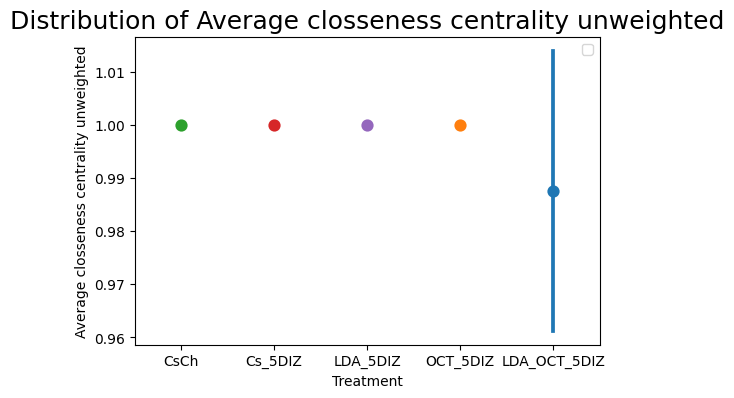

/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/home/milky/drosophila-SNA/.env/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


In [1]:
import os
import toml
import scipy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from src import settings
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, 'main.toml')
with open(CONFIG_PATH, 'r') as file:
    config = toml.load(file)  

INPUT_PATH = os.path.join(settings.RESULTS_DIR, 'global_measures')
all_treatments = fileio.load_files_from_folder(INPUT_PATH)

dataframes = []
for treatment_name, treatment_path in all_treatments.items():
    treatment_name = treatment_name.replace('.csv', '')
    if treatment_name in config['TREATMENTS']:
        df = pd.read_csv(treatment_path, index_col=0)
        df['Treatment'] = treatment_name
        dataframes.append(df)

combined_data = pd.concat(dataframes)
combined_data_reset = combined_data.reset_index()

TREATMENTS = config['TREATMENTS']

for i, measure_name in enumerate(combined_data.columns.tolist()):
    if measure_name == 'Treatment':
        continue
    
    treatment_sums = {}
    for treatment in TREATMENTS:
        treatment_sums[f'sum_{treatment}'] = combined_data_reset[combined_data_reset['Treatment'] == treatment][measure_name]

    anova_result = scipy.stats.f_oneway(*treatment_sums.values())

    all_data = np.concatenate([*treatment_sums.values()])
    group_labels = []
    for treatment in TREATMENTS:
        group_labels.extend([treatment] * len(combined_data_reset[combined_data_reset['Treatment'] == treatment][measure_name]))

    tukey_results = pairwise_tukeyhsd(all_data, group_labels)

    # if any(tukey_results.reject):
    print('='*90)
    print(measure_name)

    for treatment in treatment_sums.keys():
        print(f"{treatment} mean value: {np.mean(treatment_sums[treatment])} SD value: {np.std(treatment_sums[treatment])}")

    print(tukey_results)

    plt.figure(figsize=(6, 4))
    order = TREATMENTS
    sns.pointplot(data=combined_data_reset, x='Treatment', y=measure_name, hue='Treatment', errorbar='sd', order=order)
    plt.xlabel('Treatment')
    plt.ylabel(measure_name)
    plt.title(f'Distribution of {measure_name}', fontsize=18)
    plt.legend('')
    plt.show() 
    print('='*90)
        
        # sns.boxplot(data=combined_data_reset, x='Treatment', y=measure_name, hue='index', order=order)
        # plt.xlabel('Treatment')
        # plt.ylabel(measure_name)
        # plt.title(f'Distribution of {measure_name}', fontsize=18)
        # plt.legend('')
        # plt.show() 
        # print('='*90)